In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io,transform as sk_transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from time import gmtime, strftime
import random


In [2]:
x = random.uniform(0.7,1.3)
print(x)

0.894954800972


Data Loader Class

In [16]:
class random_augmetaion(object):
    """Applied the required tranformations"""
    
    def random_augment_image(self,face):
       
        ## mirror flipping

        # rotate image parmaeter:
        angle = math.radians(random.randrange(-30, +30))
        
        # translate image parameter
        tr_distance_x = random.randrange(-10, +10)
        tr_distance_y = random.randrange(-10, +10)
        # scaling image parameter
        scaling_val=random.uniform(0.7,1.3) 
        
        tform=sk_transform.SimilarityTransform(scale=scaling_val, rotation=angle,\
                                                    translation=(tr_distance_x, tr_distance_y))
        # transform probabilty 
        tr_probab= random.random()
        if tr_probab<=0.7:
            face = sk_transform.warp(face,inverse_map=tform)        
    
        return face
        
    
    def __call__(self,sample):
        face_1, face_2 = sample['face_1'], sample['face_2']        
        
        face_1=self.random_augment_image(face_1)
        face_2=self.random_augment_image(face_2)
        
        return {
                'face_1': face_1,
                'face_2': face_2,
                 'label':sample['label']
               }        
        
class ToTensor(object):

        
    def __call__(self,sample):
        face_1, face_2 = sample['face_1'], sample['face_2']
        
        # final resize the image
        face_1 = sk_transform.resize(face_1, (128, 128), mode='constant')
        # transpose because the axis are different in torch.image vs skimage image
        face_1=face_1.transpose((2, 0, 1))
        
         # final resize the image
        face_2 = sk_transform.resize(face_2, (128, 128), mode='constant')
        # transpose because the axis are different in torch.image vs skimage image
        face_2=face_2.transpose((2, 0, 1))
        
        label=torch.LongTensor(1, 1).zero_()
        label=sample['label']
        return {
                'face_1': torch.from_numpy(face_1),
                'face_2': torch.from_numpy(face_2),
                 'label':label
               }
    
class FacePairsDataset(Dataset):
    """Face Pairs dataset."""

    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data=pd.read_csv(txt_file,header=None)
        df=data[0].str[:].str.split(' ', expand=True)
        df.columns = ["face_1", "face_2", "label"]
        self.face_pair_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.face_pair_frame)

    def __getitem__(self, idx):
        img_name_1 = os.path.join(self.root_dir, self.face_pair_frame.loc[idx, 'face_1'])
        img_name_2 = os.path.join(self.root_dir, self.face_pair_frame.loc[idx, 'face_2'])
        face_1 = io.imread(img_name_1)
        face_2 = io.imread(img_name_2)
        label=self.face_pair_frame.loc[idx,'label']
        label=int(label)
        sample = {'face_1': face_1,'face_2':face_2,'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample


Loads and transforms the data

In [37]:
trans_train = transforms.Compose([random_augmetaion(),ToTensor()])
trans_test = transforms.Compose([ToTensor()])

face_train_dataset = FacePairsDataset(txt_file='train.txt',root_dir='lfw/',transform=trans_train)
face_test_dataset = FacePairsDataset(txt_file='test.txt',root_dir='lfw/',transform=trans_test)

N = 20
train_loader = DataLoader(dataset=face_train_dataset, batch_size=N, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=face_test_dataset, batch_size=N, shuffle=False, num_workers=4)

In [38]:
print(len(test_loader)*N)

1000


tester code for batch loading

0
1
2
3
torch.Size([20, 3, 128, 128])
torch.Size([20, 3, 128, 128])
torch.Size([20])


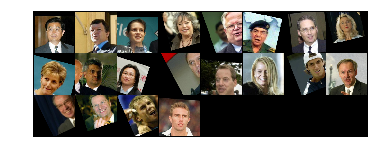

In [39]:
def show_faces_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    faces_1_batch, faces_2_batch = sample_batched['face_1'], sample_batched['face_2']
    print (faces_1_batch.shape)
    print (faces_2_batch.shape)
    labels_batch=sample_batched['label']
    print(labels_batch.shape)
    batch_size = len(faces_1_batch)ss
    im_size = faces_1_batch.size(2)
    grid_1 = utils.make_grid(faces_1_batch)
    grid_2 = utils.make_grid(faces_2_batch)
    plt.imshow(grid_1.numpy().transpose((1, 2, 0)))
    plt.imshow(grid_2.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print (i_batch)
    # sample_batched['face_1'].size() + sample_batched['face_2'].size()
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_faces_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
i=0

# Model C

In [20]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5,padding=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,padding=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1,stride=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1,stride=1)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(131072, 1024)
        
        self.b_64 = nn.BatchNorm2d(64)
        self.b_128 = nn.BatchNorm2d(128)
        self.b_256 = nn.BatchNorm2d(256)
        self.b_512 = nn.BatchNorm2d(512)
        self.b_1024 = nn.BatchNorm2d(1024)
        self.F_relu = F.relu
        self.F_max_pool2d = F.max_pool2d
        

    def forward_once(self, x):
        # Max pooling over a (2, 2) window
       
        
        #1,2,3,4
        x = self.F_relu(self.conv1(x))
        x = self.b_64(x)
        x = self.F_max_pool2d(x,2)
        
        #5,6,7,8
        x = self.F_relu(self.conv2(x))
        x = self.b_128(x)
        x = self.F_max_pool2d(x, 2)
        
        #9,10,11,12
        x = self.F_relu(self.conv3(x))
        x = self.b_256(x)
        x = self.F_max_pool2d(x,2)
        
        #13,14,15 (no max pooling)
        x = self.F_relu(self.conv4(x))
        x=self.b_512(x)
        
        # 16
        x = x.view(-1, self.num_flat_features(x))
        
        #17,18,19
        x = self.F_relu(self.fc1(x))
        x= self.b_1024(x)
        
        return x
    
    def forward(self,input1,input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




# Siamese_Net

In [21]:

class Siamese_Net(torch.nn.Module):
    

    def __init__(self):
        super(Siamese_Net, self).__init__()
        if torch.cuda.is_available():
            self.net = Net().cuda()
        else:
            self.net = Net()
        self.fc = nn.Linear(2048, 1)


    def forward(self, input1, input2):
        output_1,output_2=self.net(input1,input2)
      
        x = torch.cat((output_1,output_2), 1)
        m = nn.Sigmoid()
        output = m(self.fc(x))
        return output
    


# Optimizer, Loss

In [22]:
import torch.optim as optim
if torch.cuda.is_available():
    snet = Siamese_Net().cuda()
    criterion = nn.BCELoss().cuda()
else:
    snet = Siamese_Net()
    criterion = nn.BCELoss()
    
optimizer = optim.Adam(snet.parameters())
print(snet)


Siamese_Net (
  (net): Net (
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear (131072 -> 1024)
    (b_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (b_128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (b_256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (b_512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (b_1024): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc): Linear (2048 -> 1)
)


# Sanity Checks for parameters

In [23]:
params = list(snet.parameters())
print(len(params))
print(params[0].size())  # bases weight
print(params[2].size())  # conv2's .weight
print(params[4].size())  # conv3's .weight
print(params[6].size())  # conv4's .weight
print(params[8].size())  # conv5's .weight
print(params[10].size())  # linear 2 .weight


22
torch.Size([64, 3, 5, 5])
torch.Size([128, 64, 5, 5])
torch.Size([256, 128, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([1024, 131072])
torch.Size([64])


In [24]:
a = torch.randn(2,3,128,128)
b = torch.randn(2,3,128,128)

if torch.cuda.is_available():
    temp=snet(Variable(a).cuda(),Variable(b).cuda())
else:
    temp=snet(Variable(a),Variable(b))
    
print(temp.size())

torch.Size([2, 1])


In [25]:
def curr_accuracy():
    correct = 0
    total = 0
    count = 0
    for data in test_loader:
        count=count+1
        faces_1_batch, faces_2_batch = data['face_1'], data['face_2']
        labels_batch = data['label']

        if torch.cuda.is_available():
            input1,input2 = Variable(faces_1_batch.float().cuda()),Variable(faces_2_batch.float().cuda())
        else:
            input1,input2 = Variable(faces_1_batch.float()),Variable(faces_2_batch.float())

        outputs = snet(input1,input2)

        outputs.data[outputs.data>=0.5]=1
        outputs.data[outputs.data<=0.5]=0
            
        predicted = outputs.data

        total += labels_batch.size(0)
        labels_batch= (labels_batch.view(-1,1))

        correct += (predicted.long().cpu() == labels_batch.long()).sum()    
   
    ac = 100 * (correct / total)
    print('Accuracy of the network on the %d test images: %d %%' %(total, ac))
    return ac


In [26]:
ac_list=[]
for epoch in range(15):  # loop over the dataset multiple times
    for i, sample_batched in enumerate(train_loader):
        # get the inputs
        faces_1_batch, faces_2_batch = sample_batched['face_1'], sample_batched['face_2']
        labels_batch = sample_batched['label']
        
        # wrap them in Variable
        if torch.cuda.is_available():
            input1,input2 = Variable(faces_1_batch.float().cuda()),Variable(faces_2_batch.float().cuda())
            labels_batch = Variable(labels_batch.float().cuda())
        else:
            input1,input2 = Variable(faces_1_batch.float()),Variable(faces_2_batch.float())
            labels_batch = Variable(labels_batch.float())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = snet(input1,input2)
        outputs_flat=outputs.view(outputs.numel())
        loss = criterion(outputs_flat, labels_batch)
        loss.backward()
        optimizer.step()
        
    # ac_list.append(curr_accuracy())
    print("Epoch number ",epoch)
        
print('Finished Training')
curr_time=strftime("%Y_%m_%d_%H_%M_%S", gmtime())
save_file_path='snet_tf_'+curr_time
torch.save(snet.state_dict(), save_file_path)

Epoch number  0
Epoch number  1
Epoch number  2
Epoch number  3
Epoch number  4
Epoch number  5
Epoch number  6
Epoch number  7
Epoch number  8
Epoch number  9
Epoch number  10
Epoch number  11
Epoch number  12
Epoch number  13
Epoch number  14
Finished Training


RuntimeError: Unknown error -1

In [27]:
curr_time=strftime("%Y_%m_%d_%H_%M_%S", gmtime())
save_file_path='snet_tf_'+curr_time
torch.save(snet.state_dict(), save_file_path)

In [28]:
if torch.cuda.is_available():
    snet_load = Siamese_Net().cuda()
else:
    snet_load = Siamese_Net()  
snet_load.load_state_dict(torch.load('snet_tf_2017_11_23_22_14_44'))


In [40]:
snet=snet_load
acc_data_set = FacePairsDataset(txt_file='train.txt',root_dir='lfw/',transform=trans_train)
acc_loader = DataLoader(dataset=acc_data_set, batch_size=N, shuffle=False, num_workers=4)
curr_accuracy_2()


Accuracy of the network on the 2200 test images: 64 %


64.04545454545455

In [30]:
def curr_accuracy_2():
    correct = 0
    total = 0
    count = 0
    for data in acc_loader:
        count=count+1
        faces_1_batch, faces_2_batch = data['face_1'], data['face_2']
        labels_batch = data['label']

        if torch.cuda.is_available():
            input1,input2 = Variable(faces_1_batch.float().cuda()),Variable(faces_2_batch.float().cuda())
        else:
            input1,input2 = Variable(faces_1_batch.float()),Variable(faces_2_batch.float())

        outputs = snet(input1,input2)

        outputs.data[outputs.data>=0.5]=1
        outputs.data[outputs.data<=0.5]=0
            
        predicted = outputs.data

        total += labels_batch.size(0)
        labels_batch= (labels_batch.view(-1,1))

        correct += (predicted.long().cpu() == labels_batch.long()).sum()    
   
    ac = 100 * (correct / total)
    print('Accuracy of the network on the %d test images: %d %%' %(total, ac))
    return ac
